# Create and populate the database

In [1]:
# # Import standard libraries
# import os
import re
import json
import codecs
# import requests
import time
import dill
time.sleep(3)

from urllib.request import urlopen

# # Import third-party libraries
# import geopandas as gpd
# from geoalchemy2 import Geometry
import pandas as pd
from sqlalchemy import create_engine, Column, Integer, String, Date, MetaData, event, Table, text, LargeBinary, ForeignKey
from sqlalchemy.dialects.sqlite import insert
from sqlalchemy.orm import sessionmaker
# from sqlalchemy.event import listen
# from sqlalchemy.engine import Engine
# from sqlalchemy.ext.declarative import declarative_base

# import sqlite3
# from sqlite3 import dbapi2 as sqlite

# import fiona
# from fiona.crs import from_epsg

from src.helpers import *
from src.dbutils import *
from src.ORMutils import *
from src.models import *
from src.geo import *
from src.pdfutils import *

* #### Load the objects created in previous notebooks

In [2]:
# Load the environment
with open("environment_data/table_dicts.pkl", "rb") as f:
    env = dill.load(f)

# Restore the environment
globals().update(env)

In [3]:
for name, dataset in dataset_info_dict.items():
    if dataset.col_customizations is not None:
        for key in dataset.col_customizations.keys():
            print(dataset.col_customizations[key].short_name)
    else:
        print(f'No column info set for {dataset.column_metadata}')

Borough
Block
Lot
CD
BCT2020
BCTCB2020
CT2010
CB2010
SchoolDist
Council
ZipCode
FireComp
PolicePrct
HealthCenterDist
HealthArea
SanitBoro
SanitDist
SanitSub
Address
ZoneDist1
ZoneDist2
ZoneDist3
ZoneDist4
Overlay1
Overlay2
SPDist1
SPDist2
SPDist3
LtdHeight
SplitZone
BldgClass
LandUse
Easements
OwnerType
OwnerName
LotArea
BldgArea
ComArea
ResArea
OfficeArea
RetailArea
GarageArea
StrgeArea
FactryArea
OtherArea
AreaSource
NumBldgs
NumFloors
UnitsRes
UnitsTotal
LotFront
LotDepth
BldgFront
BldgDepth
Ext
ProxCode
IrrLotCode
LotType
BsmtCode
AssessLand
AssessTot
ExemptTot
YearBuilt
YearAlter1
YearAlter2
HistDist
Landmark
BuiltFAR
ResidFAR
CommFAR
FacilFAR
BoroCode
BBL
CondoNo
Tract2010
XCoord
YCoord
ZoneMap
ZMCode
Sanborn
TaxMap
EDesigNum
APPBBL
APPDate
PLUTOMapID
FIRM07_Flag)
NDICATO
Version
DCPEdited
Latitude
Longitude
Notes
building_num
street
sid
created_at
updated_at
bble
boro
block
lot
easement
owner
bldgcl
taxclass
ltfront
ltdepth
ext
stories
fullval
avland
avtot
exland
extot
excd1
sta

* ### Create the database engine that will be used throughout the rest of the notebook.

In [4]:
engine = create_engine(f'{SQLITE_PATH}?check_same_thread=False', echo=False)

SessionLocal = sessionmaker(bind=engine, autoflush=False, autocommit=False)

* ### Configure the database

In [5]:
@event.listens_for(engine, "connect")
def load_spatialite(dbapi_conn, connection_record):
    print("Loading SpatiaLite extension")
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("mod_spatialite")
    dbapi_conn.enable_load_extension(False)


with engine.connect() as conn:
    print("Connection established")
    result = conn.execute(text("SELECT spatialite_version()"))
    spatialite_version = result.fetchone()
    print(f"SpatiaLite version: {spatialite_version[0]}")

# Enable WAL mode
with engine.connect() as conn:
    conn.execute(text("PRAGMA journal_mode=WAL"))
    conn.execute(text("PRAGMA synchronous = NORMAL"))

# Initialize spatial metadata if not already present
with engine.connect() as conn:
    conn.execute(text("SELECT InitSpatialMetaData(1)"))

Loading SpatiaLite extension
Connection established
SpatiaLite version: 5.1.0


In [6]:
# Base = declarative_base()
metadata = MetaData()
Base.metadata.reflect(bind=engine) 

* ### Create lookup tables variables identified as categorical and for which definitions were extracted from the metadata in the previous notebook.

* There are borough codes in the PLUTO dataset, but annyoingly, in contrast to most other datasets, the borough code is a two letter inital like "BK" or "BX". Also in the PLUTO dataset, "Sanitation Borough" does use the standard numeric codes that most other NYC OpenData datasets use. All this is is to say that it requires special handling separate from my system to extract categories and create lookup tables for them programatically.

In [7]:
lookups = {k:v for k,v in col_customization_dict.items() if col_customization_dict[k].is_category == True} # Codes for overlays are to go in the same table as other zoning codes

completed_tables = [] # This is for tracking the names of tables that have been created, which will be used to avoid creating redundant tables for columns that are same-kind repeats (such as "district_1" and "district_2"), and thus will use the same lookups.

for name,table in lookups.items():
    print(f"processing {table}")
    lookup_table_name= re.sub('_[0-9]+$', '', table.new_name)
    print(f"lookup_table_name: {lookup_table_name}")
    if any([table.new_name.startswith(prefix) and table.new_name[-1].isdigit() for prefix in completed_tables]):
    # if table.new_name[0:len(table)*75] in completed_tables:
        print(f"Lookup table {lookup_table_name} already created, continuing...")
        continue
    with engine.connect() as connection:
        print(f"Creating lookup table {lookup_table_name}...")
        # lookup_table = create_lookup_table(engine=engine, lookup_table_name=lookup_table_name, text_column_name='name_or_code')
        lookup_table = create_lookup_table(Base.metadata, lookup_table_name=lookup_table_name, text_column_name='name_or_code')
        print(f"Created lookup table: {lookup_table}")
        # name_prefix = table.new_name[0:round(len(table.new_name)*.75)] # Hopefully this is a safe threshold to identify when columns are repeats of the same type
        name_prefix = lookup_table_name
        completed_tables.append(name_prefix)
        # lookup_tables[lookup_table_name] = lookup_table
        lookups[name].orm = lookup_table

# metadata.create_all(engine)
Base.metadata.create_all(engine)



processing ColCustomization(short_name='Borough', new_name='borough', dtype='String', synonyms=[], definitions=[['BX', 'Bronx'], ['BK', 'Brooklyn'], ['MN', 'Manhattan'], ['QN', 'Queens'], ['SI', 'Staten Island']], drop=False, is_category=True, is_fk=False, orm=None)
lookup_table_name: borough
Creating lookup table borough...
Created lookup table: borough_lookup
processing ColCustomization(short_name='CD', new_name='community_district', dtype='Integer', synonyms=[], definitions=[], drop=False, is_category=True, is_fk=False, orm=None)
lookup_table_name: community_district
Creating lookup table community_district...
Created lookup table: community_district_lookup
processing ColCustomization(short_name='SchoolDist', new_name='school_district', dtype='String', synonyms=[], definitions=[], drop=False, is_category=True, is_fk=False, orm=None)
lookup_table_name: school_district
Creating lookup table school_district...
Created lookup table: school_district_lookup
processing ColCustomization(sho

In [8]:
multicolumns = {'zoning_district': 4, 'commercial_overlay': 2, 'special_purpose_district': 3}
for name,repetitions in multicolumns.items():
    print(f"Setting {name} columns")
    cols = {k:v for k,v in col_customization_dict.items() if col_customization_dict[k].new_name.startswith(name)}
    main_col = [v for k,v in col_customization_dict.items() if col_customization_dict[k].new_name.endswith("_1")][0]
    for key in cols.keys():
        lookups[key].orm = main_col.orm

Setting zoning_district columns
Setting commercial_overlay columns
Setting special_purpose_district columns


In [9]:
for name,table in lookups.items():
    lookup_table = table.orm
    if lookup_table is None:
        print(f"Skipping {name}...")
        continue
    print(lookup_table)
    with engine.connect() as connection:
        for definition in table.definitions:
            if len(definition) == 2:
                try:
                    stmt = insert(lookup_table).values(id=int(definition[0]), name_or_code=definition[1]).on_conflict_do_nothing()
                except ValueError:
                    stmt = insert(lookup_table).values(name_or_code=definition[0], info=definition[1]).on_conflict_do_nothing()
            elif len(definition) == 3:
                try:
                    stmt = insert(lookup_table).values(id=int(definition[0]), name_or_code=definition[1], info=definition[2]).on_conflict_do_nothing()
                except Exception as e:
                    print(e)
                    print(definition)
                    # stmt = insert(lookup_table).values(id=definition[0], name_or_code=definition[1], info=definition[2]).on_conflict_do_nothing()
            else:
                print(definition)
                raise ValueError("Was only expecting two or three columns")
            connection.execute(stmt)
        connection.commit()
    name_prefix = table.new_name[0:round(len(table.new_name)*.75)] # Hopefully this is a safe threshold to identify when columns are repeats of the same type

borough_lookup
community_district_lookup
school_district_lookup
city_council_district_lookup
zip_code_lookup
fire_company_lookup
police_precinct_lookup
health_center_district_lookup
health_area_lookup
sanitation_district_boro_lookup
sanitation_district_number_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
zoning_district_lookup
limited_height_district_lookup
building_class_lookup
land_use_category_lookup
type_of_ownership_code_lookup
owner_name_lookup
total_building_floor_area_source_code_lookup
extension_code_lookup
proximity_code_lookup
irregular_lot_code_lookup
lot_type_lookup
basement_type_or_grade_lookup
historic_district_name_lookup
borough_code_lookup
zoning_map_code_lookup
pluto_dtm_base_map_indicator_lookup
notes_lookup
street_lookup


## Import the MaPLUTO data:
* List the layers in the file
* In this case there is only one layer, so it isn't necessary to know and specify which one to import, but including anyway for future reference.

In [10]:
# Import the MapPLUTO data from geo database file (.gdb)
gdb_path = f"{PROJECT_DATA}/files_to_use/MapPLUTO24v4.gdb"


* Import the geodatabase (.gdb) file.

In [11]:

geodata = {}
# List layers in the GDB file
layers = fiona.listlayers(gdb_path)
print("Layers in the GDB file:")
for layer in layers:
    print(layer)
    gdf = gpd.read_file(gdb_path, layer=layer)
    # gdf['borough'] = gdf['Borough'].replace(replacement_dict)
    try:
        gdf['wkb'] = gdf['geometry'].apply(lambda geom: geom.wkb if geom else None)
    except KeyError:
        pass
    geodata[layer] = gdf


Layers in the GDB file:
MapPLUTO_24v4_clipped
NOT_MAPPED_LOTS


In [12]:
geodata.keys()


dict_keys(['MapPLUTO_24v4_clipped', 'NOT_MAPPED_LOTS'])

In [13]:
col_customization_dict

{'borough': ColCustomization(short_name='Borough', new_name='borough', dtype='String', synonyms=[], definitions=[['BX', 'Bronx'], ['BK', 'Brooklyn'], ['MN', 'Manhattan'], ['QN', 'Queens'], ['SI', 'Staten Island']], drop=False, is_category=True, is_fk=False, orm=Table('borough_lookup', MetaData(), Column('id', Integer(), table=<borough_lookup>, primary_key=True, nullable=False), Column('name_or_code', String(), table=<borough_lookup>, nullable=False, default=ScalarElementColumnDefault('NO DATA')), Column('info', String(), table=<borough_lookup>), schema=None)),
 'tax_block': ColCustomization(short_name='Block', new_name='tax_block', dtype='Float', synonyms=[], definitions=[], drop=False, is_category=False, is_fk=False, orm=None),
 'tax_lot': ColCustomization(short_name='Lot', new_name='tax_lot', dtype='Float', synonyms=[], definitions=[], drop=False, is_category=False, is_fk=False, orm=None),
 'community_district': ColCustomization(short_name='CD', new_name='community_district', dtype='

* Create the table in the Sqlite database and insert the (modified) data from the gdb file.

In [14]:
gdf = geodata['MapPLUTO_24v4_clipped']
# is_whole_number = [(gdf[col] % 1 == 0).all() for col in gdf.columns if gdf[col].dtype == 'float']
is_whole_number = {(gdf[col].notna() & (gdf[col] % 1 == 0)).all() for col in gdf.columns if gdf[col].dtype == 'float'}
# is_whole_number = {col : (gdf[col] % 1 == 0).all() for col in gdf.columns if gdf[col].dtype == 'float'}
gdf.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCenterDistrict', 'HealthArea', 'Sanitboro', 'SanitDistrict',
       'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3',
       'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3',
       'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse', 'Easements',
       'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea',
       'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea',
       'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext',
       'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand',
       'AssessTot', 'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2',
       'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR',
       'BoroCode', 'BBL', 'Cond

In [15]:
gdf['ZipCode'].dtype

dtype('float64')

In [16]:
# Function to check if all non-NaN values are whole numbers
# Function to check if all non-NaN values are whole numbers
def is_whole_number_series(s):
    return (s.dropna() % 1 == 0).all() 

# Iterate over columns and change dtype to int where applicable
for col in gdf.columns:
    if  gdf[col].dtype == float and is_whole_number_series(gdf[col]):
        print(f'Column {col} is {is_whole_number_series(gdf[col])}')
        print(f'Converting {col} to integer')
        gdf[col] = gdf[col].astype('Int64')  # 'Int64' for nullable integer type in Pandas
    else:
        print(f"Skipping {col}")


Skipping Borough
Skipping Block
Skipping Lot
Column CD is True
Converting CD to integer
Skipping BCT2020
Skipping BCTCB2020
Skipping CT2010
Skipping CB2010
Skipping SchoolDist
Column Council is True
Converting Council to integer
Column ZipCode is True
Converting ZipCode to integer
Skipping FireComp
Column PolicePrct is True
Converting PolicePrct to integer
Column HealthCenterDistrict is True
Converting HealthCenterDistrict to integer
Column HealthArea is True
Converting HealthArea to integer
Skipping Sanitboro
Skipping SanitDistrict
Skipping SanitSub
Skipping Address
Skipping ZoneDist1
Skipping ZoneDist2
Skipping ZoneDist3
Skipping ZoneDist4
Skipping Overlay1
Skipping Overlay2
Skipping SPDist1
Skipping SPDist2
Skipping SPDist3
Skipping LtdHeight
Skipping SplitZone
Skipping BldgClass
Skipping LandUse
Column Easements is True
Converting Easements to integer
Skipping OwnerType
Skipping OwnerName
Column LotArea is True
Converting LotArea to integer
Column BldgArea is True
Converting BldgAr

In [17]:
from sqlalchemy import inspect
inspector = inspect(engine)
print(inspector.get_table_names())  # Ensure "basement_type_or_grade_lookup" is listed


['ElementaryGeometries', 'KNN2', 'SpatialIndex', 'basement_type_or_grade_lookup', 'borough_code_lookup', 'borough_lookup', 'building_class_lookup', 'city_council_district_lookup', 'commercial_overlay_lookup', 'community_district_lookup', 'data_licenses', 'extension_code_lookup', 'fire_company_lookup', 'geometry_columns', 'geometry_columns_auth', 'geometry_columns_field_infos', 'geometry_columns_statistics', 'geometry_columns_time', 'health_area_lookup', 'health_center_district_lookup', 'historic_district_name_lookup', 'irregular_lot_code_lookup', 'land_use_category_lookup', 'limited_height_district_lookup', 'lot_type_lookup', 'notes_lookup', 'owner_name_lookup', 'pluto_dtm_base_map_indicator_lookup', 'police_precinct_lookup', 'proximity_code_lookup', 'sanitation_district_boro_lookup', 'sanitation_district_number_lookup', 'school_district_lookup', 'spatial_ref_sys', 'spatial_ref_sys_aux', 'spatialite_history', 'special_purpose_district_lookup', 'sql_statements_log', 'street_lookup', 'to

In [18]:
rename_mappings = {v.short_name: v.new_name for v in col_customization_dict.values()}

In [19]:
gdf = gdf.rename(columns=rename_mappings)

In [20]:
print(gdf.columns)

Index(['borough', 'tax_block', 'tax_lot', 'community_district',
       'census_tract_2020', 'census_block_2020', 'census_tract_2010',
       'census_block_2010', 'school_district', 'city_council_district',
       'zip_code', 'fire_company', 'police_precinct', 'HealthCenterDistrict',
       'health_area', 'Sanitboro', 'SanitDistrict', 'sanitation_subsection',
       'address', 'zoning_district_1', 'zoning_district_2',
       'zoning_district_3', 'zoning_district_4', 'commercial_overlay_1',
       'commercial_overlay_2', 'special_purpose_district_1',
       'special_purpose_district_2', 'special_purpose_district_3',
       'limited_height_district', 'split_boundary_indicator', 'building_class',
       'land_use_category', 'number_of_easements', 'type_of_ownership_code',
       'owner_name', 'lot_area', 'total_building_floor_area',
       'commercial_floor_area', 'residential_floor_area', 'office_floor_area',
       'retail_floor_area', 'garage_floor_area', 'storage_floor_area',
       'f

In [21]:
# A few of the column names did not exactly match up due to slightly different field names than specified in the data dictionary, so these need to be renamed manually:

more_mappings = {
    "HealthCenterDistrict": "health_center_district",
    "SanitDistrict": "sanitation_district_number",
    "Sanitboro": "sanitation_district_boro",
    "FIRM07_FLAG": "2007_flood_insurance_rate_map_indicator",
    "PFIRM15_FLAG": "2015_preliminary_flood_insurance_rate_map",
}
gdf = gdf.rename(columns=more_mappings)

In [22]:
print(gdf.columns)

Index(['borough', 'tax_block', 'tax_lot', 'community_district',
       'census_tract_2020', 'census_block_2020', 'census_tract_2010',
       'census_block_2010', 'school_district', 'city_council_district',
       'zip_code', 'fire_company', 'police_precinct', 'health_center_district',
       'health_area', 'sanitation_district_boro', 'sanitation_district_number',
       'sanitation_subsection', 'address', 'zoning_district_1',
       'zoning_district_2', 'zoning_district_3', 'zoning_district_4',
       'commercial_overlay_1', 'commercial_overlay_2',
       'special_purpose_district_1', 'special_purpose_district_2',
       'special_purpose_district_3', 'limited_height_district',
       'split_boundary_indicator', 'building_class', 'land_use_category',
       'number_of_easements', 'type_of_ownership_code', 'owner_name',
       'lot_area', 'total_building_floor_area', 'commercial_floor_area',
       'residential_floor_area', 'office_floor_area', 'retail_floor_area',
       'garage_floor_a

In [23]:
from sqlalchemy import Table, MetaData, Column, Integer, String, ForeignKey, LargeBinary, Float, Date
from sqlalchemy.orm import declarative_base

# Base = declarative_base()
# metadata = MetaData()

# Reflect the existing database tables once
metadata.reflect(bind=engine)

# Function to map custom dtype to SQLAlchemy types
def map_custom_dtype(dtype):
    if dtype == 'Integer':
        return Integer
    elif dtype == 'String':
        return String
    elif dtype == 'Float':
        return Float
    elif dtype == 'Date':
        return Date
    elif dtype == 'LargeBinary':
        return LargeBinary
    else:
        raise ValueError(f"Unsupported dtype: {dtype}")

# Function to dynamically create the table class
def create_dynamic_table_class(table_name, col_customization_dict):
    attrs = {
        '__tablename__': table_name,
        'id': Column(Integer, primary_key=True, autoincrement=True),
        'geometry': Column(String),  
        'wkb': Column(LargeBinary),  # Use LargeBinary for WKB
        'Shape_Leng' : Column(Float), # Add columns not listed in the data dictionary
        'Shape_Area' : Column(Float),
    }
    
    for k, v in col_customization_dict.items():
        if any([name for name in multicolumns.keys() if name in k]):
            k = re.sub('_[0-9]$', '', k)
        col_type = map_custom_dtype(v.dtype)
        if v.is_fk:
            attrs[k] = Column(Integer, ForeignKey(f'{v.new_name}_lookup.id'))
        elif v.is_category:
            print(f'Creating id column for {v.new_name}')
            attrs[v.new_name] = Column(col_type)
            attrs[f"{v.new_name}_id"] = Column(Integer, ForeignKey(f'{k}_lookup.id'))
        else:
            attrs[v.new_name] = Column(col_type)
    
    return type(table_name, (Base,), attrs)

# Create the MapPLUTO_24v4_clipped table class
MapPLUTO24v4Clipped = create_dynamic_table_class('MapPLUTO_24v4_clipped', col_customization_dict)

# Reflect the metadata again to ensure it includes the new table class
metadata.reflect(bind=engine)

# Create all tables in the database
Base.metadata.create_all(engine)


Creating id column for borough
Creating id column for community_district
Creating id column for school_district
Creating id column for city_council_district
Creating id column for zip_code
Creating id column for fire_company
Creating id column for police_precinct
Creating id column for health_center_district
Creating id column for health_area
Creating id column for sanitation_district_number
Creating id column for zoning_district_1
Creating id column for zoning_district_2
Creating id column for zoning_district_3
Creating id column for zoning_district_4
Creating id column for commercial_overlay_1
Creating id column for commercial_overlay_2
Creating id column for special_purpose_district_1
Creating id column for special_purpose_district_2
Creating id column for special_purpose_district_3
Creating id column for limited_height_district
Creating id column for building_class
Creating id column for land_use_category
Creating id column for type_of_ownership_code
Creating id column for owner_na

In [24]:
datetime_cols = [col.new_name for col in col_customization_dict.values() if col.dtype == 'Date']
# datetime_cols = [col for col in datetime_cols if col is not None]
datetime_cols

['apportionment_date']

In [25]:
from sqlalchemy.orm import sessionmaker
from shapely import wkb

# Create a session
session = SessionLocal()

# gdf = geodata['MapPLUTO_24v4_clipped']
def format_float(value):
    return str(value).rstrip('0').rstrip('.') if '.' in str(value) else str(value)

batch_size = 5000
with SessionLocal() as session:
    for start in range(0, len(gdf), batch_size):
        batch = gdf.iloc[start:start + batch_size]
        for idx, row in batch.iterrows():
            try:
                if row['apportionment_date']:
                    row['apportionment_date'] = parseDateString(row['apportionment_date'])
                # if row['address']:
                #     row = split_address(row)
                for col in gdf.columns:
                    val = row[col]
                    if isinstance(val, pd.Series):
                        try:
                            first_value = row[col].iloc[0]
                            row[col] = first_value
                        except Exception as e:
                            print(f"Error processing Series in column {col} at row {idx}: {e}")
                    # Replace NA values with None so that SQLAlchemy inserts them as NULL:
                    if pd.isna(val):
                        # print(f"Found NA value in column {col} at row {idx}, inserting as NULL")
                        row[col] = None
                # Prepare the geometry and entry object
                geometry_wkb = row['geometry'].wkb if row['geometry'] else None
                pluto_entry = MapPLUTO24v4Clipped(
                    geometry=geometry_wkb,
                    **{col: row[col] for col in gdf.columns if col not in ['geometry']}
                )
                session.add(pluto_entry)
            except Exception as e:
                print(f"Error at row index {idx}")
                for col in gdf.columns:
                    try:
                        print(f"Column: {col}, Value: {row[col]}, Type: {type(row[col])}")
                    except Exception as sub_e:
                        print(f"Error printing column {col}: {sub_e}")
                raise e  # re-raise after logging for further debugging
        session.commit()


In [26]:
del gdf

* Make a test plot to verify that the geodata was stored correctly

DataFrame columns: Index(['zip_code', 'geometry'], dtype='object')
  zip_code                                           geometry
0     None  MULTIPOLYGON (((981176.548 194654.257, 981179....
1    10004  MULTIPOLYGON (((980898.728 191409.779, 980881....
2    10004  MULTIPOLYGON (((979185.332 191646.482, 979184....
3    10004  MULTIPOLYGON (((979185.332 191646.482, 979141....
4    10004  MULTIPOLYGON (((980098.929 189698.799, 980082....
Index(['geometry', 'zip_code'], dtype='object')


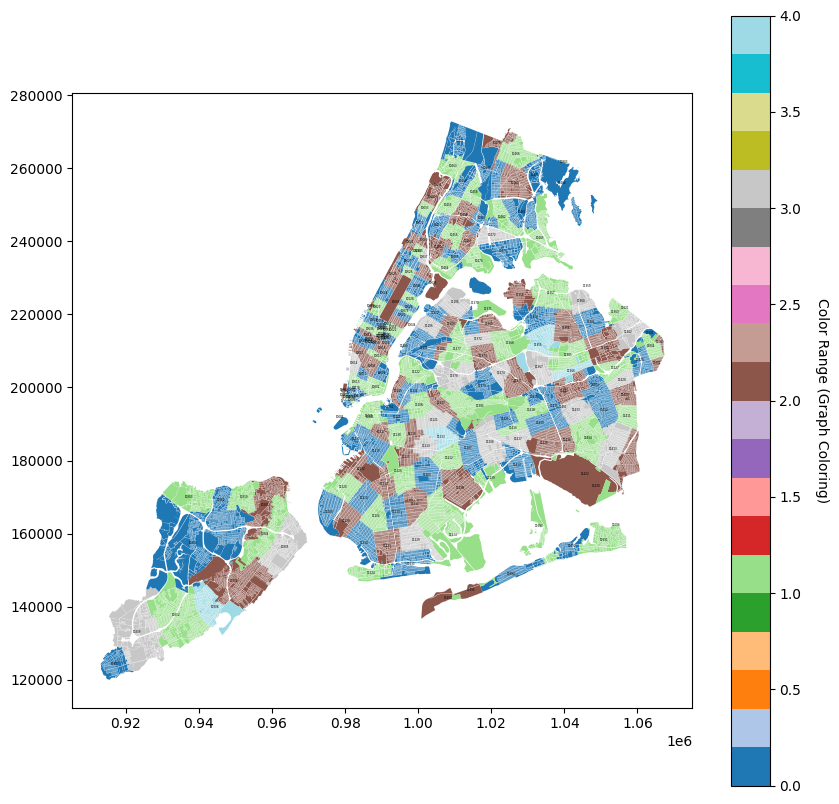

In [27]:
import geopandas as gpd
import pandas as pd
from shapely import wkb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from sqlalchemy import create_engine, event, text

# Read the data from the database
query = "SELECT zip_code, geometry FROM MapPLUTO_24v4_clipped"
df = pd.read_sql(query, engine)

# Debug: Print the DataFrame columns
print("DataFrame columns:", df.columns)

# Convert the geometry column from WKB to Shapely geometries
df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if x else None)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Print the GeoDataFrame
print(gdf.head())

# Ensure that zip_code is preserved during the dissolve process
merged_gdf = gdf.dissolve(by='zip_code', aggfunc={'zip_code': 'first'})  # Explicit aggregation of zip_code

# Check if zip_code is now present after dissolving
print(merged_gdf.columns)  # Should include 'zip_code'

# Create a new adjacency graph based on the merged geometries
G = nx.Graph()

# Add nodes and edges based on adjacency of merged shapes
for i, shape1 in merged_gdf.iterrows():
    for j, shape2 in merged_gdf.iterrows():
        if i != j and shape1.geometry.touches(shape2.geometry):
            G.add_edge(i, j)

# Perform graph coloring to ensure adjacent shapes don't share the same color
color_map = nx.coloring.greedy_color(G, strategy="largest_first")

# Plot the map with the colors assigned
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Normalize the color map to cover the full range of the node indices
norm = mcolors.Normalize(vmin=min(color_map.values()), vmax=max(color_map.values()))
sm = plt.cm.ScalarMappable(cmap=plt.cm.tab20, norm=norm)

# Color the merged geometries based on the graph coloring using the full palette
merged_gdf['color'] = merged_gdf.index.map(color_map)
merged_gdf.plot(ax=ax, color=[sm.to_rgba(i) for i in merged_gdf['color']], edgecolor='black', linewidth=0, legend=False)

# Add labels at the center of each merged shape
for _, row in merged_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row['zip_code']), fontsize=2, ha='center', va='center')

# Add a colorbar to visualize the full range of colors
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Color Range (Graph Coloring)', rotation=270, labelpad=20)

plt.savefig("/home/james/Massive/PROJECTDATA/map_output_zip_shuffled2.pdf", format="pdf")

plt.show()

In [28]:
# to_recode = [col for col in col_customization_dict.values() if not col.is_fk and col.is_category]
to_recode = {k:v for k,v in lookups.items() if not v.is_fk and v.is_category}
to_recode

{'borough': ColCustomization(short_name='Borough', new_name='borough', dtype='String', synonyms=[], definitions=[['BX', 'Bronx'], ['BK', 'Brooklyn'], ['MN', 'Manhattan'], ['QN', 'Queens'], ['SI', 'Staten Island']], drop=False, is_category=True, is_fk=False, orm=Table('borough_lookup', MetaData(), Column('id', Integer(), table=<borough_lookup>, primary_key=True, nullable=False), Column('name_or_code', String(), table=<borough_lookup>, nullable=False, default=ScalarElementColumnDefault('NO DATA')), Column('info', String(), table=<borough_lookup>), schema=None)),
 'community_district': ColCustomization(short_name='CD', new_name='community_district', dtype='Integer', synonyms=[], definitions=[], drop=False, is_category=True, is_fk=False, orm=Table('community_district_lookup', MetaData(), Column('id', Integer(), table=<community_district_lookup>, primary_key=True, nullable=False), Column('name_or_code', String(), table=<community_district_lookup>, nullable=False, default=ScalarElementColumn

In [29]:
for colname in to_recode.keys():
    print(f"Processing {colname}...")
    lookup_table = to_recode[colname].orm
    source_table_name = 'MapPLUTO_24v4_clipped'
    lookup_table_name = lookup_table.name
    text_column_name = colname
    s = time.process_time() # start timer
    populate_lookup_table(engine, lookup_table, source_table_name, lookup_table_name, text_column_name)
    e = time.process_time() # end time
    print(f"Populating {colname} took {e-s} seconds")


Processing borough...
Column creation skipped or failed: (sqlite3.OperationalError) duplicate column name: borough_id
[SQL: ALTER TABLE MapPLUTO_24v4_clipped ADD COLUMN borough_id INTEGER]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Loading SpatiaLite extension
Populating borough took 4.657410359999972 seconds
Processing community_district...
Column creation skipped or failed: (sqlite3.OperationalError) duplicate column name: community_district_id
[SQL: ALTER TABLE MapPLUTO_24v4_clipped ADD COLUMN community_district_id INTEGER]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Populating community_district took 5.950697706000028 seconds
Processing school_district...
Column creation skipped or failed: (sqlite3.OperationalError) duplicate column name: school_district_id
[SQL: ALTER TABLE MapPLUTO_24v4_clipped ADD COLUMN school_district_id INTEGER]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Populating school_district took 4.682533271000011 sec

# Add more datasets to db

In [30]:


# def insert_dataset(session, jsonfile, engine, prefix, keepcols, column_names, datetime_cols):
#     with open(jsonfile, "rb") as f:
#         batch_size = 1000
#         rows_to_insert = []
#         for idx, row in enumerate(ijson.items(f, "item")):
#             if idx == 0:
#                 DynamicTable = create_table_for_dataset(column_names, keepcols, prefix, row, engine)
#             row = [textClean(val) if type(val) is str else val for val in row ]
#             row_data = dict(zip([col[0] for col in keepcols], [row[column_names.index(col[0])] for col in keepcols]))
#             row_data = { key:(parseDateString(row_data[key]) if key in datetime_cols and row_data[key] is not None else row_data[key]) for key in row_data.keys()}
#             # This is to deal with a peculiarity in of the datasets
#             row_data = split_address(row_data)
#             rows_to_insert.append(row_data)
#             if len(rows_to_insert) == 0:
#                 raise(Exception("Row empty!"))
#             if (idx + 1) % batch_size == 0:
#                 session.bulk_insert_mappings(DynamicTable, rows_to_insert)
#                 session.commit()
#                 rows_to_insert = []
#         if rows_to_insert:
#             try:
#                 session.bulk_insert_mappings(DynamicTable, rows_to_insert)
#                 session.commit()
#             except Exception as e:
#                 print(f"Error inserting batch at index {idx}: {e}")
#                 session.rollback()
#     session.close()


# def prep_col_info(configs, name):
#     prefix = f"{configs['prefix']}/{name}"
#     cols_to_drop = configs['cols_to_drop']
#     cols_to_rename = configs['cols_to_rename']
#     datype_exceptions = configs['datype_exceptions']
#     datatype_mappings = configs['datatype_mappings']
#     with open(f'{prefix}_data_types.txt', 'r') as f:
#         data_types = f.read().replace('"', '').strip().lower().split('\n')
#         for idx,datatype in enumerate(data_types):
#             if datatype in datatype_mappings.keys():
#                 data_types[idx] = datatype_mappings[datatype]
#     with open(prefix + '_colnames.txt', 'r') as f:
#         # Clean up the column names
#         column_names = f.read().replace('"', '').split('\n')
#         column_names = fix_colnames(column_names, cols_to_rename)
#     cols = dict(zip(column_names, data_types))
#     for key in cols.keys():
#         if key in datype_exceptions.keys():
#             cols[key] = datype_exceptions[key]
#     # Drop columns that I don't think I will need
#     keepcols = [(col, cols[col]) for col in cols.keys() if col not in cols_to_drop]
#     # print("keepcols is", keepcols)
#     datetime_cols = [col[0] if col[1] is Date else None for idx,col in enumerate(keepcols)]
#     datetime_cols = [col for col in datetime_cols if col is not None]
#     return column_names, cols, keepcols, datetime_cols

# def preprocess_dataset(engine, shared_dataset_configs, specific_dataset_config, name):
#     configs = merge_dicts(shared_dataset_configs, specific_dataset_config) 
#     column_names, cols, keepcols, datetime_cols = prep_col_info(configs, name)
#     prefix = configs['prefix'] + '/' + name
#     insert_dataset(prefix + "_rows.json", engine,prefix, keepcols, column_names, datetime_cols)


# def create_table(column_names, data_list, engine, table_name):
#     table_name = f"{lookup_table_name}_lookup"
    
#     if table_name in metadata.tables:  # Avoid redefining existing tables
#         print(f"Skipping existing table: {table_name}")
#         return
    
#     # Dynamically create a unique ORM class for the table
#     table_class = type(f"{table_name.capitalize()}Table", (Base,), {
#         "__tablename__": f"{table_name}",
#         "__table_args__": {'extend_existing': True},
#         **columns
#     })
#     return table_class



# def create_lookup_table(metadata, lookup_table_name, text_column_name):
#     table_name = f"{lookup_table_name}_lookup"
    
#     if table_name in metadata.tables:  # Avoid redefining existing tables
#         print(f"Skipping existing table: {table_name}")
#         return
    
#     lookup_table = Table(
#         table_name,
#         metadata,
#         Column("id", Integer, primary_key=True, autoincrement=True),
#         Column(text_column_name, String, unique=True, nullable=False, default="NO DATA"),
#         Column("info", String, unique=False, nullable=True, default=None),
#     )
#     return lookup_table

In [31]:
datatype_mappings = {"meta_data" : String, "calendar_date" : Date, "number" : Float, "text" : String, "point" : String}

In [32]:
for field, value in vars(dataset).items():
    print(f"{field}: {value}")

name: DOB Certificate Of Occupancy
short_name: cert_of_occupancy
format: json
main_url: https://data.cityofnewyork.us/Housing-Development/DOB-Certificate-Of-Occupancy/bs8b-p36w/about_data
data_url: https://data.cityofnewyork.us/api/views/bs8b-p36w/rows.json?accessType=DOWNLOAD
dataset_path: /home/james/Massive/PROJECTDATA/nyc_real_estate_data/files_to_use/cert_of_occupancy_rows.json
data_dict_path: None
standard: True
geodata: False
metadata: {'id': 'bs8b-p36w', 'name': 'DOB Certificate Of Occupancy', 'assetType': 'dataset', 'averageRating': 0, 'category': 'Housing & Development', 'createdAt': 1498850799, 'description': 'A Certificate of Occupancy (CO) states a building’s legal use and/or type of permitted occupancy. New buildings must have a CO, and existing buildings must have a current or amended CO when there is a change in use, egress or type of occupancy. No one may legally occupy a building until the Department has issued a Certificate of Occupancy or Temporary Certificate of Oc

In [33]:
for field, value in vars(dataset).items():
    print(f"{field}: {value}")

name: DOB Certificate Of Occupancy
short_name: cert_of_occupancy
format: json
main_url: https://data.cityofnewyork.us/Housing-Development/DOB-Certificate-Of-Occupancy/bs8b-p36w/about_data
data_url: https://data.cityofnewyork.us/api/views/bs8b-p36w/rows.json?accessType=DOWNLOAD
dataset_path: /home/james/Massive/PROJECTDATA/nyc_real_estate_data/files_to_use/cert_of_occupancy_rows.json
data_dict_path: None
standard: True
geodata: False
metadata: {'id': 'bs8b-p36w', 'name': 'DOB Certificate Of Occupancy', 'assetType': 'dataset', 'averageRating': 0, 'category': 'Housing & Development', 'createdAt': 1498850799, 'description': 'A Certificate of Occupancy (CO) states a building’s legal use and/or type of permitted occupancy. New buildings must have a CO, and existing buildings must have a current or amended CO when there is a change in use, egress or type of occupancy. No one may legally occupy a building until the Department has issued a Certificate of Occupancy or Temporary Certificate of Oc

In [34]:
def set_column(colname, dtype):
    args = {
        "primary_key": False,  # Marks the column as a primary key.
        "nullable": True,  # Disallows NULL values.
        "unique": False,  # Enforces unqiue values.
        "index": True,  # Creates an index on this column.
        "default" : None, # Python-side default
        "server_default": 'NULL',  # SQL-side default value (as a string).
        "autoincrement": True,  # Controls autoincrement behavior.
    }
    return Column(colname, dtype, **args)

In [35]:
def create_table(columns, engine, tabname):
    columns = {'local_id': Column(Integer, primary_key=True)} | {colname: set_column(colname, dtype) for colname,dtype in columns.items() if isinstance(colname, str)}
    columns['sid'] = Column(String, unique=True, nullable=False)
    print(columns)
    table_class = type(f"{tabname.capitalize()}Table", (Base,), {
        "__tablename__": f"{tabname}",
        "__table_args__": {'extend_existing': True},
        **columns
    })
    print(f'Creating table class {tabname}: {table_class}')
    # Create the table in the database
    Base.metadata.create_all(engine)
    return table_class

def create_table_for_dataset(columns, prefix, engine):
    tabname = re.sub('.*/', '', prefix)
    print(f'Creating table {tabname}')
    DynamicTable = create_table(columns, engine, tabname)
    if DynamicTable is None:
        raise(Exception("DynamicTable not made!"))
    return DynamicTable

In [ ]:
import ijson
from shapely import wkt
from geoalchemy2.shape import from_shape

import time
import ijson
from shapely import wkt
from geoalchemy2.shape import from_shape

import ijson.backends.yajl2_cffi as ijson
from shapely import from_wkt  # Vectorized conversion function in Shapely 2.0
from geoalchemy2.shape import from_shape

from shapely import from_wkt  # Vectorized conversion function in Shapely 2.0


def insert_dataset(jsonfile, columns, batch_size=10000):
    session = SessionLocal()
    col_names = list(columns.keys())
    rows_to_insert = []
    
    with open(jsonfile, "rb") as f:
        for idx, row in enumerate(ijson.items(f, "item")):
            if idx == 0:
                datetime_cols = [key for key in columns if columns[key] is Date]
                DynamicTable = create_table_for_dataset(
                    columns=dataset.col_types, 
                    prefix=dataset.short_name, 
                    engine=engine
                )
                # Prepare the insert statement once.
                insert_stmt = DynamicTable.__table__.insert().prefix_with("OR IGNORE")
            # Clean text.
            row = [textClean(val) if isinstance(val, str) else val for val in row]
            # Build complete row dictionary.
            row_data = {col_name: (row[i] if i < len(row) else None)
                        for i, col_name in enumerate(col_names)}
            
            # Save raw WKT in a temporary key.
            row_data['_raw_geocoded_column'] = row_data.get('geocoded_column')
            row_data['geocoded_column'] = None  # Set geometry for now to None.
            
            # Process datetime values.
            temp = {}
            for key in row_data:
                if key == '_raw_geocoded_column':
                    temp[key] = row_data[key]
                else:
                    temp[key] = (parseDateString(row_data[key])
                                 if key in datetime_cols and row_data[key] is not None
                                 else row_data[key])
            row_data = temp
            
            rows_to_insert.append(row_data)
            
            if (idx + 1) % batch_size == 0:
                # Batch convert geometry using Shapely's vectorized from_wkt.
                raw_wkts = [r.get('_raw_geocoded_column') for r in rows_to_insert]
                try:
                    shapely_geoms = from_wkt(raw_wkts)
                except Exception as e:
                    print(f"Error converting batch geometry at row {idx}: {e}")
                    shapely_geoms = [None] * len(rows_to_insert)
                # Convert each Shapely geometry via GeoAlchemy2's from_shape.
                geoms = [from_shape(geom, srid=4326) if geom is not None else None
                         for geom in shapely_geoms]
                for r, geom in zip(rows_to_insert, geoms):
                    r['geocoded_column'] = geom
                    r.pop('_raw_geocoded_column', None)
                    
                # Instead of using bulk_insert_mappings, execute the insert statement.
                batch_start = time.perf_counter()
                session.execute(insert_stmt, rows_to_insert)
                session.commit()
                batch_end = time.perf_counter()
                print(f"Batch {(idx+1)//batch_size} inserted in {batch_end - batch_start:.3f} seconds (processed {batch_size} rows)")
                rows_to_insert = []
                
        if rows_to_insert:
            print(f'rows_to_insert: {rows_to_insert}')
            raw_wkts = [r.get('_raw_geocoded_column') for r in rows_to_insert]
            try:
                shapely_geoms = from_wkt(raw_wkts)
            except Exception as e:
                print(f"Error converting final batch geometry: {e}")
                shapely_geoms = [None] * len(rows_to_insert)
            geoms = [from_shape(geom, srid=4326) if geom is not None else None
                     for geom in shapely_geoms]
            for r, geom in zip(rows_to_insert, geoms):
                r['geocoded_column'] = geom
                r.pop('_raw_geocoded_column', None)
            try:
                session.execute(insert_stmt, rows_to_insert)
                session.commit()
            except Exception as e:
                print(f"Error inserting final batch at index {idx}: {e}")
                session.rollback()
    session.close()


In [47]:
for k,v in dataset_info_dict.items():
    print(f'{k} : {v}')

mapPLUTO : DatasetInfo(name='Primary Land Use Tax Lot Output - Map (MapPLUTO)', short_name='mapPLUTO', format='zip', id='f888-ni5f', main_url='https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-Map-MapPLUTO-/f888-ni5f/about_data', metadata_url='https://data.cityofnewyork.us/api/views/f888-ni5f.json', data_url='https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v4_fgdb.zip', dataset_path='/home/james/Massive/PROJECTDATA/nyc_real_estate_data/files_to_use/MapPLUTO24v4.gdb', data_dict_path=None, standard=False, geodata=True, metadata={}, column_metadata={}, cardinality_ratios={}, data_dict_url='https://data.cityofnewyork.us/api/views/f888-ni5f/files/a5f455ae-002e-4e78-ae17-f3dcc59c236d?download=true&filename=PLUTODD22v3.pdf', other_files=[('97ca6e86-32cc-46f1-b85c-8d01e17e1602', 'PlutoReadme22v3.pdf')], attribution='Department of City Planning (DCP)', createdAt=1374771826, description='Extensive land use and geographic data at t

In [48]:

for name,dataset in dataset_info_dict.items():
    if dataset.format == 'json':
        print(f'Starting dataset {dataset.short_name}')
        print(f'The dataset to be processed is {dataset}')
        jsonfile = dataset.dataset_path
        columns = dataset.col_types
        print(f'Columns are {columns}')
        insert_dataset(jsonfile, columns, batch_size = 50000)
   

Starting dataset assessments
The dataset to be processed is DatasetInfo(name='Property Valuation and Assessment Data', short_name='assessments', format='json', id='yjxr-fw8i', main_url='https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data/yjxr-fw8i/about_data', metadata_url='https://data.cityofnewyork.us/api/views/yjxr-fw8i.json', data_url='https://data.cityofnewyork.us/api/views/yjxr-fw8i/rows.json?accessType=DOWNLOAD', dataset_path='/home/james/Massive/PROJECTDATA/nyc_real_estate_data/files_to_use/assessments_rows.json', data_dict_path=None, standard=True, geodata=False, metadata={'id': 'bs8b-p36w', 'name': 'DOB Certificate Of Occupancy', 'assetType': 'dataset', 'averageRating': 0, 'category': 'Housing & Development', 'createdAt': 1498850799, 'description': 'A Certificate of Occupancy (CO) states a building’s legal use and/or type of permitted occupancy. New buildings must have a CO, and existing buildings must have a current or amended CO when there i

TypeError: 'NoneType' object is not iterable

In [ ]:
print(dataset.short_name)
print(len(columns))
print(columns)
print(dataset.col_types)

In [ ]:
print(len(columns))
print(columns)

In [ ]:
for colname,dtype in columns.items():
    print(colname)
    if isinstance(colname, str):
        set_column(colname, dtype)


In [ ]:
for field, value in vars(dataset).items():
    print(f"{field}: {value}")

In [ ]:
print(len(row), row)
print(len(dataset.col_types), dataset.col_types)